In [1]:
# Module: packages.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from PIL import Image
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt


In [2]:
# Pfade zu den Daten
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'

In [3]:


def load_data(image_dir, excel_path, target_size=(196, 256)):  # Zielgröße anpassen
    # Lade die Excel-Datei
    df = pd.read_excel(excel_path)
    
    # Stelle sicher, dass die Spalte 'mittlerer_durchmesser' vorhanden ist
    if 'mittlerer_durchmesser' not in df.columns:
        raise ValueError("Die Excel-Datei muss eine Spalte 'mittlerer_durchmesser' enthalten.")
    
    # Lade die Bilder und die entsprechenden Durchmesser
    image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir))]

    # Stelle sicher, dass die Anzahl der Bilder mit der Anzahl der Einträge in der Excel-Datei übereinstimmt
    assert len(image_paths) == len(df), "Anzahl der Bilder und Durchmesser stimmt nicht überein."
    
    # Lade die Bilder in eine Liste und skaliere sie auf target_size
    images = []
    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                img = img.convert('L')  # Konvertiere in Graustufen
                img = img.resize(target_size)  # Resize auf die Zielgröße
                images.append(np.array(img, dtype=np.float32))  # Konvertiere zu float32
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

    diameters = df['mittlerer_durchmesser'].values
    
    # Konvertiere die Listen zu NumPy-Arrays
    images = np.array(images)
    diameters = np.array(diameters, dtype=np.float32)  # Konvertiere zu float32
    
    # Normalisierung der Bilder
    images /= 255.0
    
    # Füge die Kanal-Dimension hinzu
    if len(images.shape) == 3:
        images = images[..., np.newaxis]  # Hinzufügen der Kanal-Dimension
    
    # Aufteilen in Trainings- und Testdaten
    X_train, X_test, y_train, y_test = train_test_split(images, diameters, test_size=0.15, random_state=44)
    
    # Debugging: Form der Arrays überprüfen
    print("Shape von X_train:", X_train.shape)
    print("Shape von X_test:", X_test.shape)
    print("Shape von y_train:", y_train.shape)
    print("Shape von y_test:", y_test.shape)
    
    return X_train, X_test, y_train, y_test


In [4]:
# Module: model.py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner import HyperModel, RandomSearch
import numpy as np

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential([
            # Erste Convolutional Schicht
            Conv2D(hp.Int('conv_1_filters', min_value=64, max_value=256, step=32), 
                   (3, 3), activation='relu', input_shape=(196, 256, 1)),
            MaxPooling2D((2, 2)),
            Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)),
            
            # Zweite Convolutional Schicht
            Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=32), 
                   (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)),
            
            # Dritte Convolutional Schicht
            Conv2D(hp.Int('conv_3_filters', min_value=128, max_value=512, step=64), 
                   (5, 5), activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)),
            
            # Vierte Convolutional Schicht
            Conv2D(hp.Int('conv_4_filters', min_value=256, max_value=1024, step=128), 
                   (5, 5), activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(hp.Float('dropout_4', 0.2, 0.5, step=0.1)),
            
            # Fünfte Convolutional Schicht (optional)
            Conv2D(hp.Int('conv_5_filters', min_value=512, max_value=2048, step=256), 
                   (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),

            # Flatten-Schicht
            Flatten(),
            
            # Dense Schicht
            Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), 
                  activation='relu'),
            Dropout(hp.Float('dropout_5', 0.3, 0.6, step=0.1)),
            
            # Output-Schicht
            Dense(1)
        ])

        # Kompiliere das Modell
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, loss='mean_absolute_error')
        return model

def build_and_train_model(X_train, y_train, X_test, y_test, epochs=1000, model_save_path='C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'):
    # Füge eine Dimension für die Kanäle hinzu (falls notwendig)
    if len(X_train.shape) == 3:
        X_train = X_train[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

    # Hyperparameter-Tuner initialisieren
    tuner = RandomSearch(
        MyHyperModel(),
        objective='val_loss',
        max_trials=10,  # Anzahl der Versuche, du kannst diese Zahl anpassen
        executions_per_trial=1,
        directory='hyperparam_tuning',
        project_name='sphaeroidauswertung'
    )

    # Tuner suchen lassen
    tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

    # Beste Hyperparameter abrufen
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Modell mit den besten Hyperparametern bauen
    model = tuner.hypermodel.build(best_hps)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5)

    # Modell trainieren
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_test, y_test),
                        callbacks=[early_stopping, reduce_lr])

    # Speichern des Modells
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    return model, history


C:\Users\chris\AppData\Local\Temp\ipykernel_5456\2795631383.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [5]:
# Module: evaluation.py


def load_trained_model(model_save_path):
    # Modell laden
    model = load_model(model_save_path)
    return model

def evaluate_model(model_path, X_test, y_test):
    # Modell laden
    try:
        model = load_model(model_path)
        print("Model successfully loaded.")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Überprüfen Sie die Eingabeformate
    print("Shape von X_test beim Modellbewerten:", X_test.shape)
    print("Shape von y_test beim Modellbewerten:", y_test.shape)

    # Model evaluieren
    try:
        loss = model.evaluate(X_test, y_test)
        print(f"Test loss: {loss}")
    except Exception as e:
        print(f"Error evaluating model: {e}")

    # Trainings- und Validierungsverlust plotten
    try:
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error plotting history: {e}")



Trial 10 Complete [00h 23m 37s]
val_loss: 77.60503387451172

Best val_loss So Far: 13.967738151550293
Total elapsed time: 02h 02m 02s
Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 770ms/step - loss: 175.1554 - val_loss: 73.2385 - learning_rate: 0.0010
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 766ms/step - loss: 85.5069 - val_loss: 99.6968 - learning_rate: 0.0010
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 764ms/step - loss: 69.4627 - val_loss: 33.5002 - learning_rate: 0.0010
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 767ms/step - loss: 77.1613 - val_loss: 80.5236 - learning_rate: 0.0010
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 756ms/step - loss: 38.8415 - val_loss: 53.3516 - learning_rate: 0.0010
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 766ms/step - loss: 38.2244 - val_loss: 61.5738 - learning_rate: 0.0010
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 764ms/step - loss: 36.9665 - val_loss: 17.7472 - learning_rate: 0.0010
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 762ms/step - los

Model saved to C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5


Model successfully loaded.
Shape von X_test beim Modellbewerten: (54, 256, 196, 1)
Shape von y_test beim Modellbewerten: (54,)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 9.2977
Test loss: 9.370105743408203


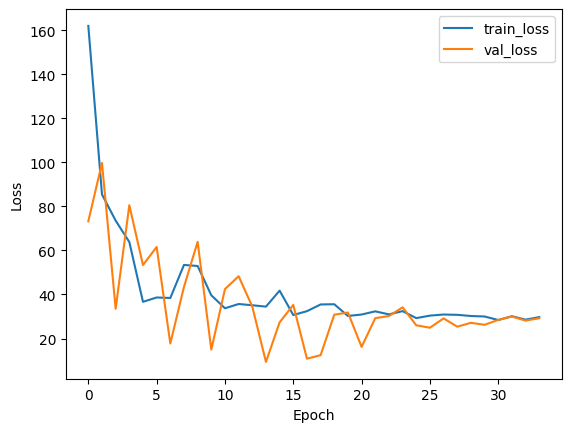

In [6]:


# Daten laden
X_train, X_test, y_train, y_test = load_data(image_dir, excel_path)

# Debugging: Überprüfen der Shapes vor dem Training
print("Shape von X_train vor dem Training:", X_train.shape)
print("Shape von X_test vor dem Training:", X_test.shape)

# Modell erstellen und trainieren
model, history = build_and_train_model(X_train, y_train, X_test, y_test, epochs=1000, model_save_path='C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5')

# Modell bewerten
evaluate_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5', X_test, y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

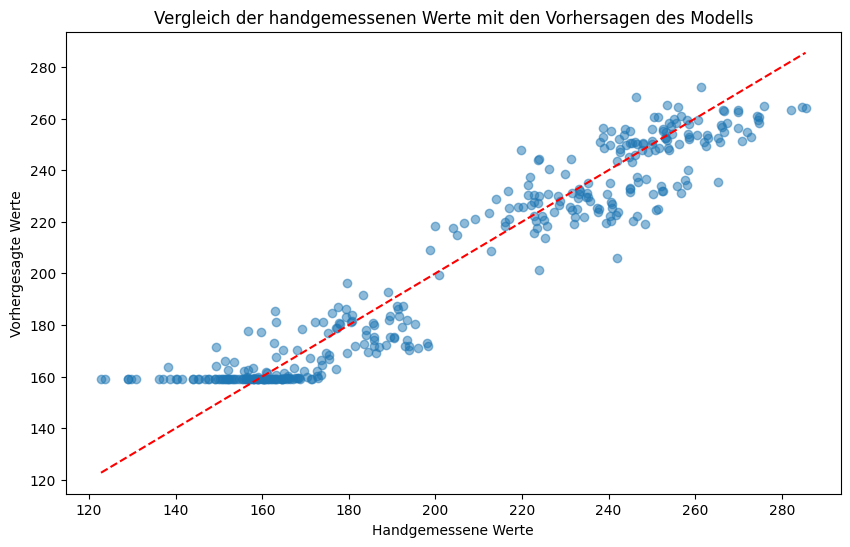

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import os

# Pfade zu den Daten und zum Modell
image_folder_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
manual_data_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'

def load_data(image_folder_path, excel_path):
    # Liste der Bilder im Ordner (wir nehmen an, sie sind bereits sortiert)
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    
    # Überprüfen, ob Bilder vorhanden sind
    if len(image_files) == 0:
        raise ValueError("Keine Bilddateien gefunden. Überprüfe den Pfad und das Verzeichnis.")
    
    # Lade und normalisiere die Bilder
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    
    X = np.array(images)
    
    # Lade die handgemessenen Daten
    manual_data = pd.read_excel(excel_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen, ob die Anzahl der Bilder mit den handgemessenen Werten übereinstimmt
    if len(image_files) != len(manual_measurements):
        raise ValueError("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    
    y = np.array(manual_measurements)
    
    # Aufteilung der Daten in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return prediction[0][0]

def evaluate_model(model_path, image_folder_path, manual_data_path):
    # Modell laden
    model = load_model(model_path)

    # Daten laden
    X_train, X_test, y_train, y_test = load_data(image_folder_path, manual_data_path)

    # Vorhersagen für alle Bilder im Testset
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    predictions = [predict_image(os.path.join(image_folder_path, image_file), model) for image_file in image_files]
    predictions = np.array(predictions)
    
    # Vorhersagen für das Testset
    y_test_predictions = model.predict(X_test)

    # Die erste Spalte als handgemessene Werte verwenden
    manual_data = pd.read_excel(manual_data_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values

    # Überprüfen der Anzahl der Bilder und der Anzahl der handgemessenen Werte
    print(f"Anzahl der Bilder: {len(predictions)}")
    print(f"Anzahl der handgemessenen Werte: {len(manual_measurements)}")

    # Wenn die Anzahl der Vorhersagen und der manuellen Werte übereinstimmt
    if len(predictions) == len(manual_measurements):
        # Scatterplot erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_measurements, predictions, alpha=0.5)
        plt.xlabel('Handgemessene Werte')
        plt.ylabel('Vorhergesagte Werte')
        plt.title('Vergleich der handgemessenen Werte mit den Vorhersagen des Modells')
        plt.plot([min(manual_measurements), max(manual_measurements)], [min(manual_measurements), max(manual_measurements)], color='red', linestyle='--')
        plt.show()
    else:
        print("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")

# Modell bewerten
evaluate_model(model_path, image_folder_path, manual_data_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

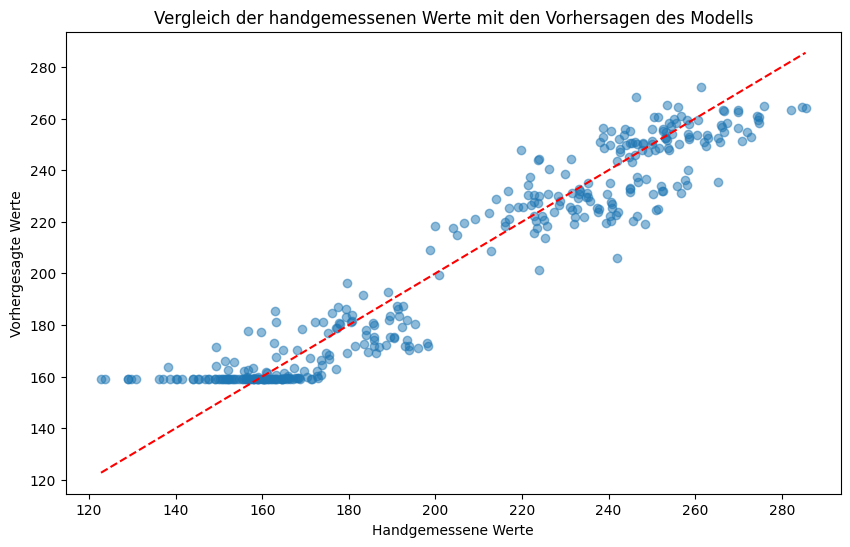

Durchschnittliche Abweichung (MAE): 9.582190026026685
R²-Wert: 0.9178140480103466


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import os

# Pfade zu den Daten und zum Modell
image_folder_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
manual_data_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'

def load_data(image_folder_path, excel_path):
    # Liste der Bilder im Ordner (wir nehmen an, sie sind bereits sortiert)
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    
    # Überprüfen, ob Bilder vorhanden sind
    if len(image_files) == 0:
        raise ValueError("Keine Bilddateien gefunden. Überprüfe den Pfad und das Verzeichnis.")
    
    # Lade und normalisiere die Bilder
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    
    X = np.array(images)
    
    # Lade die handgemessenen Daten
    manual_data = pd.read_excel(excel_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen, ob die Anzahl der Bilder mit den handgemessenen Werten übereinstimmt
    if len(image_files) != len(manual_measurements):
        raise ValueError("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    
    y = np.array(manual_measurements)
    
    # Aufteilung der Daten in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  # Normalisiere das Bild
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return prediction[0][0]

def evaluate_model(model_path, image_folder_path, manual_data_path):
    # Modell laden
    model = load_model(model_path)

    # Daten laden
    X_train, X_test, y_train, y_test = load_data(image_folder_path, manual_data_path)

    # Vorhersagen für alle Bilder im Testset
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    predictions = [predict_image(os.path.join(image_folder_path, image_file), model) for image_file in image_files]
    predictions = np.array(predictions)
    
    # Vorhersagen für das Testset
    y_test_predictions = model.predict(X_test).flatten()
    
    # Die erste Spalte als handgemessene Werte verwenden
    manual_data = pd.read_excel(manual_data_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen der Anzahl der Bilder und der Anzahl der handgemessenen Werte
    print(f"Anzahl der Bilder: {len(predictions)}")
    print(f"Anzahl der handgemessenen Werte: {len(manual_measurements)}")

    # Sicherstellen, dass die Anzahl der Vorhersagen mit der Anzahl der Testwerte übereinstimmt
    if len(predictions) == len(manual_measurements):
        # Scatterplot erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_measurements, predictions, alpha=0.5)
        plt.xlabel('Handgemessene Werte')
        plt.ylabel('Vorhergesagte Werte')
        plt.title('Vergleich der handgemessenen Werte mit den Vorhersagen des Modells')
        plt.plot([min(manual_measurements), max(manual_measurements)], [min(manual_measurements), max(manual_measurements)], color='red', linestyle='--')
        plt.show()

        # Berechnung der Metriken
        mae = mean_absolute_error(manual_measurements, predictions)
        r2 = r2_score(manual_measurements, predictions)
        
        # Ausgabe der Metriken
        print(f"Durchschnittliche Abweichung (MAE): {mae}")
        print(f"R²-Wert: {r2}")
    else:
        print("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")

# Modell bewerten
evaluate_model(model_path, image_folder_path, manual_data_path)
